In [1]:
import numpy as np
from Scripts.Configs.ConfigClass import Config
from Scripts.DataManager.GraphConstructor.GraphConstructor import TextGraphType
from lightning.pytorch.loggers import CSVLogger
import os
from Scripts.DataManager.GraphLoader.AmazonReviewGraphDataModule import AmazonReviewGraphDataModule
import time

config = Config(r'C:\Users\fardin\Projects\ColorIntelligence')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = 'cuda'
batch_size = 16

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
tag_dep_seq_sent = TextGraphType.DEPENDENCY | TextGraphType.TAGS | TextGraphType.SEQUENTIAL | TextGraphType.SENTENCE
data_manager = AmazonReviewGraphDataModule(config, True, True, shuffle=True, num_data_load = 200, device='cpu', batch_size=batch_size, graph_type=tag_dep_seq_sent, load_preprocessed_data = True)

self.num_data_load: 200
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/AmazonReview\full\graph_var.txt
 0 graph loaded
 100 graph loaded


In [3]:
t_dataloader = data_manager.train_dataloader()
v_dataloader = data_manager.val_dataloader()
X1, y1 = next(iter(t_dataloader))
X2, y2 = next(iter(v_dataloader))

In [4]:
X1.x_dict['dep']

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [5]:
from torch import nn, Tensor
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, BatchNorm, SAGEConv
class HeteroGCNConv(nn.Module):
    def __init__(self, in_feature, out_feature, dropout = 0.0) -> None:
        super().__init__()
        self.conv1 = GATv2Conv(in_feature, int(out_feature/2), heads=2, edge_dim=1, add_self_loops=False)
        self.batch_norm = BatchNorm(out_feature)
        self.dropout= nn.Dropout(dropout)
        
    def forward(self, x: Tensor, edge_index: Tensor, edge_weights: Tensor) -> Tensor:
        x = self.conv1(x, edge_index)
        x = self.batch_norm(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        return x

In [6]:
# from torch_geometric.nn import to_hetero
# hetero_model = to_hetero(HeteroGCNConv(300, 1024, 0.2), X2.metadata())
# pre = hetero_model(X2.x_dict, X2.edge_index_dict, X2.edge_attr_dict)

In [7]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
from torch import Tensor
import torch
from typing import Dict
import torch_geometric
from torch.nn import Linear
from torch_geometric.nn import GATv2Conv, GCNConv, GCN2Conv, DenseGCNConv, dense_diff_pool, BatchNorm, global_mean_pool, global_add_pool, global_max_pool, MemPooling, SAGEConv, to_hetero, HeteroBatchNorm
from torch_geometric.nn import Sequential as GSequential
from torch_geometric.utils import to_dense_adj
from torch import nn, Tensor
import torch.nn.functional as F
from torch_geometric.data import HeteroData
class HeteroGcnGatModel1(torch.nn.Module):
    def __init__(self,
                 input_feature: int, out_features: int,
                 metadata,
                 base_hidden_feature: int=256,
                 dropout=0.1):
        
        super(HeteroGcnGatModel1, self).__init__()
        self.input_features = input_feature
        self.num_out_features = out_features
        self.bsh: int = base_hidden_feature
        bsh2: int = int(self.bsh/2)
        bsh4: int = int(self.bsh/4)
        bsh8: int = int(self.bsh/8)
        
        self.conv1 = to_hetero(HeteroGCNConv(input_feature, self.bsh, dropout), metadata)
        self.conv2 = to_hetero(HeteroGCNConv(self.bsh, self.bsh, dropout), metadata)
        self.conv3 = to_hetero(HeteroGCNConv(self.bsh, self.bsh, dropout), metadata)
        self.conv4 = to_hetero(HeteroGCNConv(self.bsh, self.bsh, dropout), metadata)
        self.conv5 = to_hetero(HeteroGCNConv(self.bsh, self.bsh, dropout), metadata)
            
        # self.encoder = GSequential('x_dict, edge_index_dict, edge_weights_dict', [
        #     (to_hetero(HeteroGCNConv(input_feature, self.bsh, dropout), metadata), 'x_dict, edge_index_dict, edge_weights_dict ->x1'),
        #     (to_hetero(HeteroGCNConv(self.bsh, self.bsh, dropout), metadata), 'x1, edge_index_dict, edge_weights_dict ->x1'),
        #     (to_hetero(HeteroGCNConv(self.bsh, bsh2, dropout), metadata), 'x1, edge_index_dict, edge_weights_dict -> x2'),
        #     (to_hetero(HeteroGCNConv(bsh2, bsh2, dropout), metadata), 'x2, edge_index_dict, edge_weights_dict -> x2'),
        #     (to_hetero(HeteroGCNConv(bsh2, bsh2, dropout), metadata), 'x2, edge_index_dict, edge_weights_dict -> x2'),
        #     (lambda x1, x2: (x1, x2), 'x1, x2 -> x1, x2')
            
            # (to_hetero(HeteroGCNConv(bsh2, bsh4, dropout), metadata), 'x2, edge_index_dict, edge_weights_dict -> x3'),
            # (to_hetero(HeteroGCNConv(bsh4, bsh4, dropout), metadata), 'x3, edge_index_dict, edge_weights_dict -> x3'),
            # (to_hetero(HeteroGCNConv(bsh4, bsh4, dropout), metadata), 'x3, edge_index_dict, edge_weights_dict -> x3'),
            # (to_hetero(HeteroGCNConv(bsh4, bsh8, dropout), metadata), 'x3, edge_index_dict, edge_weights_dict -> x4'),
            # (to_hetero(HeteroGCNConv(bsh8, bsh8, dropout), metadata), 'x4, edge_index_dict, edge_weights_dict -> x4'),
            # (to_hetero(HeteroGCNConv(bsh8, bsh8, dropout), metadata), 'x4, edge_index_dict, edge_weights_dict -> x4'),
            # (lambda x1, x2, x3, x4: (x1, x2, x3, x4), 'x1, x2, x3, x4 -> x1, x2, x3, x4')
        # ])
        
        # print(f'bsh8: {bsh8}')
        # self.attention = GSequential('x3, x4, edge_index, edge_weights', [
        #     (GATv2Conv(bsh8, bsh8, 2, edge_dim=1, dropout=dropout), 'x4, edge_index, edge_weights ->x4'),
        #     (BatchNorm(bsh4), 'x4->x4'),
        #     (nn.ReLU(), 'x4->x4'),
            
        #     (GCN2Conv(bsh4, 0.5, 0.1, 2), 'x4, x3, edge_index, edge_weights->x3'),
        #     (BatchNorm(bsh4), 'x3->x3'),
        #     (nn.ReLU(), 'x3->x3'),
        #     (GCNConv(bsh4, bsh4), 'x3, edge_index, edge_weights -> x3'),
        #     (BatchNorm(bsh4), 'x3->x3'),
        #     (nn.ReLU(), 'x3->x3'),
            
        #     (GATv2Conv(bsh4, bsh4, 2, edge_dim=1, dropout=dropout), 'x3, edge_index, edge_weights ->x3'),
        #     (BatchNorm(bsh2), 'x3->x3'),
        #     (nn.ReLU(), 'x3->x3'),
        #     (lambda x3, x4: (x3, x4), 'x3, x4 -> x3, x4')
        # ])
        
        # self.decoder = GSequential('x1, x2, x3, edge_index, edge_weights', [
            
        #     (GCN2Conv(bsh2, 0.5, 0.1, 2), 'x3, x2, edge_index, edge_weights->x2'),
        #     (BatchNorm(bsh2), 'x2->x2'),
        #     (nn.ReLU(), 'x2->x2'),
        #     (nn.Dropout(dropout), 'x2->x2'),
        # self.decoder = GSequential('x1, x2, edge_index, edge_weights', [
        #     (GCNConv(bsh2, bsh2), 'x2, edge_index, edge_weights -> x2'),
        #     (BatchNorm(bsh2), 'x2->x2'),
        #     (nn.ReLU(), 'x2->x2'),
        #     (nn.Dropout(dropout), 'x2->x2'),
        #     (GCNConv(bsh2, self.bsh), 'x2, edge_index->x2'),
        #     (BatchNorm(self.bsh), 'x2->x2'),
        #     (nn.ReLU(), 'x2->x2'),
        #     (nn.Dropout(dropout), 'x2->x2'),
            
        #     (GCN2Conv(self.bsh, 0.5, 0.1, 2), 'x2, x1, edge_index, edge_weights->x1'),
        #     (BatchNorm(self.bsh), 'x1->x1'),
        #     (nn.ReLU(), 'x1->x1'),
        #     (nn.Dropout(dropout), 'x1->x1'),
        #     (GCNConv(self.bsh, self.bsh), 'x1, edge_index, edge_weights ->x1'),
        #     (BatchNorm(self.bsh), 'x1->x1'),
        #     (nn.ReLU(), 'x1->x1'),
        #     (nn.Dropout(dropout), 'x1->x1'),
        #     (GCNConv(self.bsh, self.bsh), 'x1, edge_index, edge_weights ->x1'),
        #     (BatchNorm(self.bsh), 'x1->x1'),
        #     (nn.ReLU(), 'x1->x1'),
        #     (nn.Dropout(dropout), 'x1->x1')
        # ])
        self.mem_pool = MemPooling(self.bsh, self.bsh, 4, 2)
        self.output_layer = Linear(self.bsh, self.num_out_features)
        
        self.dep_embedding = torch.nn.Linear(45, 300)
        self.tag_embedding = torch.nn.Linear(50, 300)
        
        
    def forward(self, x: HeteroData) -> Tensor:
        # x1_dict, x2_dict = self.encoder(x.x_dict, x.edge_index_dict, x.edge_attr_dict)
        x_dict = {key: x.x_dict[key] for key in x.x_dict}
        print(x_dict['dep'].shape)
        print(x_dict['tag'].shape)
        x_dict['dep'] = self.dep_embedding(x_dict['dep'])
        x_dict['tag'] = self.tag_embedding(x_dict['tag'])
        print(f"x.x_dict['dep'].shape: {x_dict['dep'].shape}")
        print(f"x.x_dict['tag'].shape: {x_dict['tag'].shape}")
        x1_dict = self.conv1(x_dict, x.edge_index_dict, x.edge_attr_dict)
        x1_dict = self.conv2(x1_dict, x.edge_index_dict, x.edge_attr_dict)
        x1_dict = self.conv3(x1_dict, x.edge_index_dict, x.edge_attr_dict)
        x1_dict = self.conv4(x1_dict, x.edge_index_dict, x.edge_attr_dict)
        x1_dict = self.conv5(x1_dict, x.edge_index_dict, x.edge_attr_dict)
        
        # x1_dict, x2_dict, x3_dict, x4_dict = self.encoder(x.x_dict, x.edge_index_dict, x.edge_attr_dict)
        # x_att, x4 = self.attention(x3_dict["word"], x4_dict["word"], 
        #                            x.edge_index_dict[('word', 'seq', 'word')],
        #                            x.edge_attr_dict[('word', 'seq', 'word')])
        # x_dec = self.decoder(x1_dict["word"], x2_dict["word"], x_att, 
        #                      x.edge_index_dict[('word', 'seq', 'word')],
        #                      x.edge_attr_dict[('word', 'seq', 'word')])
        
        x_pooled, S = self.mem_pool(x1_dict["word"], x['word'].batch)
        x_pooled = x_pooled.view(x_pooled.shape[0], -1)
        out = self.output_layer(x_pooled)
        return out

In [8]:
# dep_embedding = torch.nn.Linear(45, 300).to(device)
# print(X1.x_dict['dep'].shape)
# print(dep_embedding)
# dep_embedding(X1.x_dict['dep'].to(torch.float32))

In [9]:
# torch.nn.functional.one_hot(torch.tensor(5)).to(torch.float32).dtype

In [13]:
X1.metadata()

(['dep', 'word', 'tag', 'sentence', 'general'],
 [('dep', 'dep_word', 'word'),
  ('word', 'word_dep', 'dep'),
  ('tag', 'tag_word', 'word'),
  ('word', 'word_tag', 'tag'),
  ('word', 'seq', 'word'),
  ('general', 'general_sentence', 'sentence'),
  ('sentence', 'sentence_general', 'general'),
  ('word', 'word_sentence', 'sentence'),
  ('sentence', 'sentence_word', 'word')])

In [14]:
X1.edge_index_dict[('word', 'word_sentence', 'sentence')]

tensor([[   0,    0,    0,  ..., 1154, 1154, 1154],
        [   0,    1,    2,  ...,   93,   94,   95]])

In [15]:
X1.x_dict['word'].shape

torch.Size([1165, 300])

In [16]:
X1.x_dict['sentence'].shape

torch.Size([74, 300])

In [10]:
X1 = X1.to(device)

In [11]:
X1.x_dict['dep'].device

device(type='cpu')

In [12]:
torch_model = HeteroGcnGatModel1(300, 1, X1.metadata(), 256, dropout=0.2)
torch_model = torch_model.to(device)
print(next(iter(torch_model.parameters())).device)
print(torch_geometric.nn.summary(torch_model, X1.to(device)))

cpu
torch.Size([720, 45])
torch.Size([800, 50])
x.x_dict['dep'].shape: torch.Size([720, 300])
x.x_dict['tag'].shape: torch.Size([800, 300])


IndexError: Encountered an index error. Please ensure that all indices in 'edge_index' point to valid indices in the interval [0, 73] (got interval [0, 197])

In [ ]:
from Scripts.Models.LightningModels.LightningModels import BinaryLightningModel
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import lightning as L
from lightning.pytorch.tuner import Tuner

In [ ]:
callbacks = [
    ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True),
    EarlyStopping(patience=50, mode='max', monitor='val_acc')
]
lightning_model = BinaryLightningModel(torch_model,
                                 torch.optim.Adam(torch_model.parameters(), lr=0.00000354, weight_decay=0.00055),
                                       torch.nn.BCEWithLogitsLoss(),
                                       learning_rate=0.00000354,
                                       batch_size=batch_size,
                                       ).to(device)
trainer = L.Trainer(
            callbacks=callbacks,
            max_epochs=500,
            accelerator='gpu',
            logger=CSVLogger(save_dir='logs/', name='HeteroGat1'),
            num_sanity_val_steps=0)

NameError: name 'torch_model' is not defined

bbbb


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 86 steps due to diverging loss.
Learning rate set to 3.981071705534973e-05
Restoring states from the checkpoint path at c:\Users\fardin\Projects\ColorIntelligence\.lr_find_9c01ce8f-8540-4a32-af6a-2028228d02c1.ckpt
Restored all states from the checkpoint at c:\Users\fardin\Projects\ColorIntelligence\.lr_find_9c01ce8f-8540-4a32-af6a-2028228d02c1.ckpt


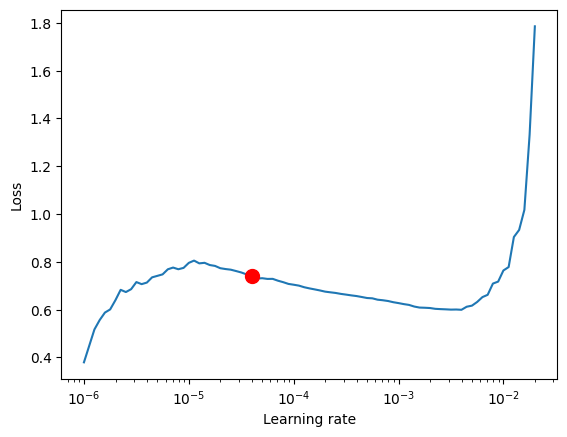

In [ ]:
tuner = Tuner(trainer)
results = tuner.lr_find(lightning_model, datamodule=data_manager, min_lr=0.0000001,max_lr=0.1)
fig = results.plot(suggest=True)

In [69]:
torch.max(X1['word'].x)

tensor(0., device='cuda:0')

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/model_logs\version_4\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


bbbb


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 3.981071705534973e-05
Restoring states from the checkpoint path at ~\Desktop\.lr_find_0fb15d6a-9797-4bf3-b1de-6e994663f1e7.ckpt
Restored all states from the checkpoint at ~\Desktop\.lr_find_0fb15d6a-9797-4bf3-b1de-6e994663f1e7.ckpt
c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\ModelsManager\ModelManager.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


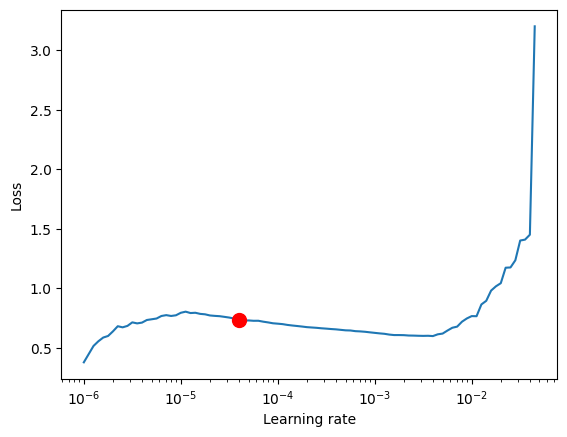

In [82]:
suggested_lr = model_manager.tune(data_manager=data_manager, min_lr=1e-6, max_lr=1e-1)

In [18]:
model_manager.ckpt_path = None

In [83]:
model_manager.fit(datamodule=data_manager, max_epochs=50)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


bbbb



  | Name      | Type               | Params
-------------------------------------------------
0 | model     | HeteroGcnGatModel1 | 2.7 M 
1 | loss_func | BCEWithLogitsLoss  | 0     
2 | train_acc | BinaryAccuracy     | 0     
3 | val_acc   | BinaryAccuracy     | 0     
4 | test_acc  | BinaryAccuracy     | 0     
-------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.926    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:58: Detected KeyboardInterrupt, attempting graceful shutdown...


In [16]:
model_manager.fit(datamodule=data_manager, max_epochs=500, ckpt_path='best')

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


bbbb


ValueError: `.fit(ckpt_path="best")` is set but `ModelCheckpoint` is not configured to save the best model.

In [87]:
model_manager.logger.version

4

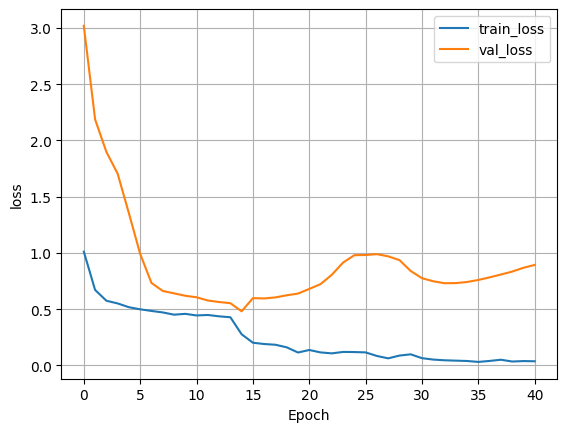

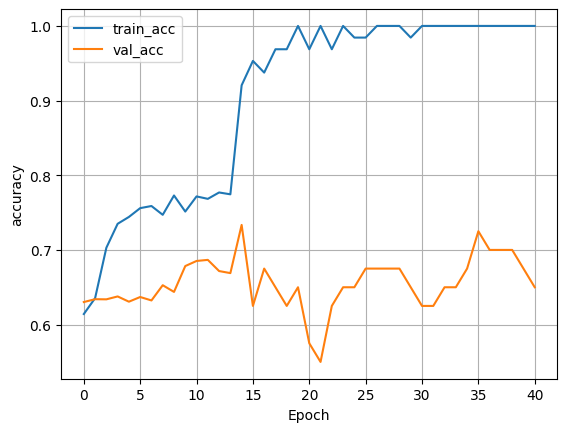

In [88]:
model_manager.plot_csv_logger()

In [92]:
import matplotlib.pyplot as plt
import pandas as pd
from os import path
def plot_csv_logger(csv_path, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc']):
    metrics = pd.read_csv(csv_path)

    aggregation_metrics = []
    agg_col = 'epoch'
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggregation_metrics.append(agg)

    df_metrics = pd.DataFrame(aggregation_metrics)
    df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
    df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
    plt.show()

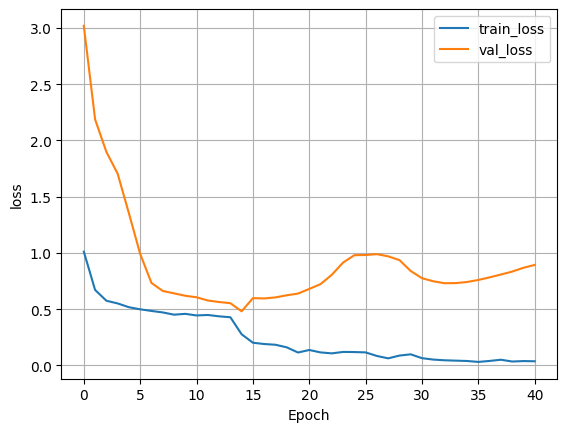

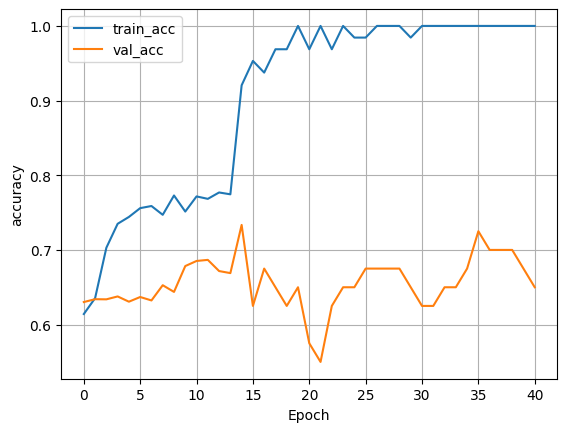

In [93]:
plot_csv_logger(r'C:\Users\fardin\Projects\ColorIntelligence\logs\model_logs\version_4\metrics.csv')